In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gymnasium as gym
import secrets
from setting import ENVIRONMENTS

COLORS = [f"#{secrets.token_hex(3)}" for _ in range(50)]

def geo_mean(a):
    # a = np.asarray(a)|
    # return np.exp(np.log(a.clip(1e-16)).mean(axis=0))
    return np.median(a, axis=0)
    
def align(time, x, y):
    return np.interp(time, x, y)

def load_data(env_folder):
    stats_list = []
    for strat in os.listdir(env_folder):
        path = os.path.join(env_folder, strat)
        if not os.path.isdir(path): continue
        for i, (run) in enumerate(os.listdir(path)):
            path = os.path.join(env_folder, strat, run)
            if not os.path.isdir(path): continue
            stats = pd.read_csv(os.path.join(path, "stats.csv"), skipinitialspace=True)
            stats['run'] = i
            stats['folder'] = run
            stats['strat'] = strat
            sig, lamb = strat.split("sigma-")[1].split("-lambda-")
            stats['sigma0'] = float(sig)
            stats['lambda'] = int(lamb)
            stats_list.append(stats)
        
    return pd.concat(stats_list, ignore_index=True)


def plot_whitebg(ax, time, y, label, color, linestyle="-"):
    ax.plot(
        time,
        y,
        color="white",
        linewidth=3,
        alpha=1,
    )

    ax.plot(
        time,
        y,
        color=color,
        label=label,
        linewidth=2,
        alpha=1,
        linestyle=linestyle
    )


def plot_all_strats_for_env(env_folder, dt=1000, plot_runs=False, return_df=False, xlim=None):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    max_t = 0

    time = meta = thres = env = None
    stats_list = []
    
    for strat, color in zip(sorted(os.listdir(env_folder)), COLORS):
        means_best = []
        means_current = []
        test_means_best = []
        test_means_current = []
        sigma = []
        pop_std = []
        path = os.path.join(env_folder, strat)
        if not os.path.isdir(path): continue
        for i, (run) in enumerate(os.listdir(path)):
            path = os.path.join(env_folder, strat, run)
            
            stats = pd.read_csv(os.path.join(path, "stats.csv"), skipinitialspace=True)

            if len(stats) == 0: continue
            stats['run'] = i
            stats['folder'] = run
            stats['strat'] = strat
            stats_list.append(stats)
            with open(os.path.join(path, "settings.json")) as f:
                meta = json.load(f)
                
            if env is None:
                env = ENVIRONMENTS[meta['env_name']]
                thres = env.reward_threshold
                time = np.linspace(0, env.max_train_timesteps,  10000)

            max_t = max(max_t, max(stats.n_train_timesteps))
            means_best.append(np.interp(time, stats.n_train_timesteps, stats.best))
            means_current.append(np.interp(time, stats.n_train_timesteps, stats.current))
            test_means_best.append(np.interp(time, stats.n_train_timesteps, stats.best_median))
            test_means_current.append(np.interp(time, stats.n_train_timesteps, stats.current_median))

            sigma.append(np.interp(time, stats.n_train_timesteps, stats.sigma))
            pop_std.append(np.interp(time, stats.n_train_timesteps, stats.population_std))
            
            if plot_runs:
                ax1.plot(time, means_best[-1], color=color, alpha=0.4, zorder=-1)
                ax2.plot(time, means_current[-1], color=color, alpha=0.4, zorder=-1)
                ax3.plot(time, test_means_best[-1], color=color, alpha=0.4, zorder=-1)
                ax4.plot(time, test_means_current[-1], color=color, alpha=0.4, zorder=-1)
    
        try:

            plot_whitebg(ax1, time, geo_mean(means_current), strat, color)
            plot_whitebg(ax2, time, geo_mean(test_means_current), strat, color)

            
        
            # if strat != "ars-v1":
            #     plot_whitebg(ax3, time, np.mean(sigma, axis=0), strat, color)
            # plot_whitebg(ax4, time, np.mean(pop_std, axis=0), strat, color)
                
            plot_whitebg(ax3, time, geo_mean(means_best), strat, color)
            plot_whitebg(ax4, time, geo_mean(test_means_best), strat, color)
        
        except Exception as err:
            print(str(err))
            continue
    
    for ax in ax1, ax2, ax3, ax4:
        if thres:
            plot_whitebg(ax, time, np.ones(len(time)) * thres, "reward-threshold", "red")
        ax.set_ylabel("returns")
        ax.set_xlabel("# train timesteps")
        ax.grid()
        ax.set_xlim(0, xlim or max_t)
        
    ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax1.set_title("current return (train)")
    ax2.set_title("current return (test)")
    ax3.set_title("best return (train)")
    ax4.set_title("best return (test)")
    # ax3.set_ylabel("sigma")
    # ax3.set_yscale("log") 
    # ax4.set_ylabel("pop std")
    
    
    plt.suptitle((meta["env_name"]))
    # plt.savefig(meta['env_name'] + ".png")
    #plt.show()
    if return_df:
        return pd.concat(stats_list, ignore_index=True)


def plot_x_final(env_folder, strats = None, show_trials = True, version = "mean"):
    f, ax = plt.subplots()
    if strats is None:
        strats = os.listdir(env_folder)
        
    for strat, color in zip(strats, colors.TABLEAU_COLORS):
        means = []
        for i, (run) in enumerate(os.listdir(os.path.join(env_folder, strat))):
            path = os.path.join(env_folder, strat, run)
            stats = pd.read_csv(os.path.join(path, "stats.csv"), skipinitialspace=True)


            with open(os.path.join(path, "settings.json")) as f:
                meta = json.load(f)
            
            policy_folder = os.path.join(path, "policies")
            if not os.path.isdir(policy_folder):
                continue
            
            policy, *_ = sorted(
                [x for x in os.listdir(policy_folder) if version in x],
                key=lambda x: -int(x.split("-")[1])
            )
            policy_vector = np.load(os.path.join(policy_folder, policy))
            if show_trials:
                ax.plot(range(len(policy_vector)), policy_vector, color=color, alpha=.5, zorder=-1)
            means.append(policy_vector.ravel())
        
        m = np.median(means, axis=0)
        std = np.std(means, axis=0)
        x = range(len(m))
        plot_whitebg(ax, x, m, strat, color)
        plt.fill_between(x, m - std, m + std, alpha=.3, color=color)

    ax.legend()
    ax.grid()
    # plt.savefig(meta['env_name'] + "coordinates.png")

def show_summary(folder_name, plot_runs=False, xlim=None):
    data = plot_all_strats_for_env(folder_name, return_df=True, plot_runs=plot_runs, xlim=xlim)    
    
    def show_best_so_far(data, current=True):
        data_key, file_key = "current_test", "mean"
        if not current:
            data_key, file_key = "best_test", "best"
        best = data.loc[data[data_key].idxmax()]
        display(pd.DataFrame(best[["strat", "folder", "generation",  "n_train_episodes", "n_train_timesteps", data_key]]).T)
        env = os.path.basename(folder_name)
        print(f"python main.py --env={env} --play={folder_name}/{best['strat']}/{best['folder']}/policies/t-{best['generation']}-{file_key}")
        print(f"code {folder_name}/{best['strat']}/{best['folder']}/policies/videos/test-episode-0.mp4")
        last_save_t = best.generation - (best.generation % 5)
        
        w = np.load(os.path.join(folder_name, best.strat, best.folder, "policies", f"t-{last_save_t}-{file_key}.npy"))
        plt.plot(w, label=f"{data_key} ({best['strat']})")
    plt.figure(figsize=(14, 4))    
    show_best_so_far(data)
    show_best_so_far(data, False)
    plt.grid()
    plt.legend()
    return data

strat              folder generation  \
72427  cma-es-norm-sigma-5.00e+00-lambda-23  1704013804.0588558       1580   

      n_train_episodes n_train_timesteps current_test  
72427            37920          53529685       2205.0

python main.py --env=SpaceInvaders-v5 --play=data/SpaceInvaders-v5/cma-es-norm-sigma-5.00e+00-lambda-23/1704013804.0588558/policies/t-1580-mean
code data/SpaceInvaders-v5/cma-es-norm-sigma-5.00e+00-lambda-23/1704013804.0588558/policies/videos/test-episode-0.mp4


strat              folder generation  \
286772  csa-norm-sigma-1.00e+00-lambda-23  1703956626.7827754       1325   

       n_train_episodes n_train_timesteps best_test  
286772            31800          39601693    2635.0

python main.py --env=SpaceInvaders-v5 --play=data/SpaceInvaders-v5/csa-norm-sigma-1.00e+00-lambda-23/1703956626.7827754/policies/t-1325-best
code data/SpaceInvaders-v5/csa-norm-sigma-1.00e+00-lambda-23/1703956626.7827754/policies/videos/test-episode-0.mp4


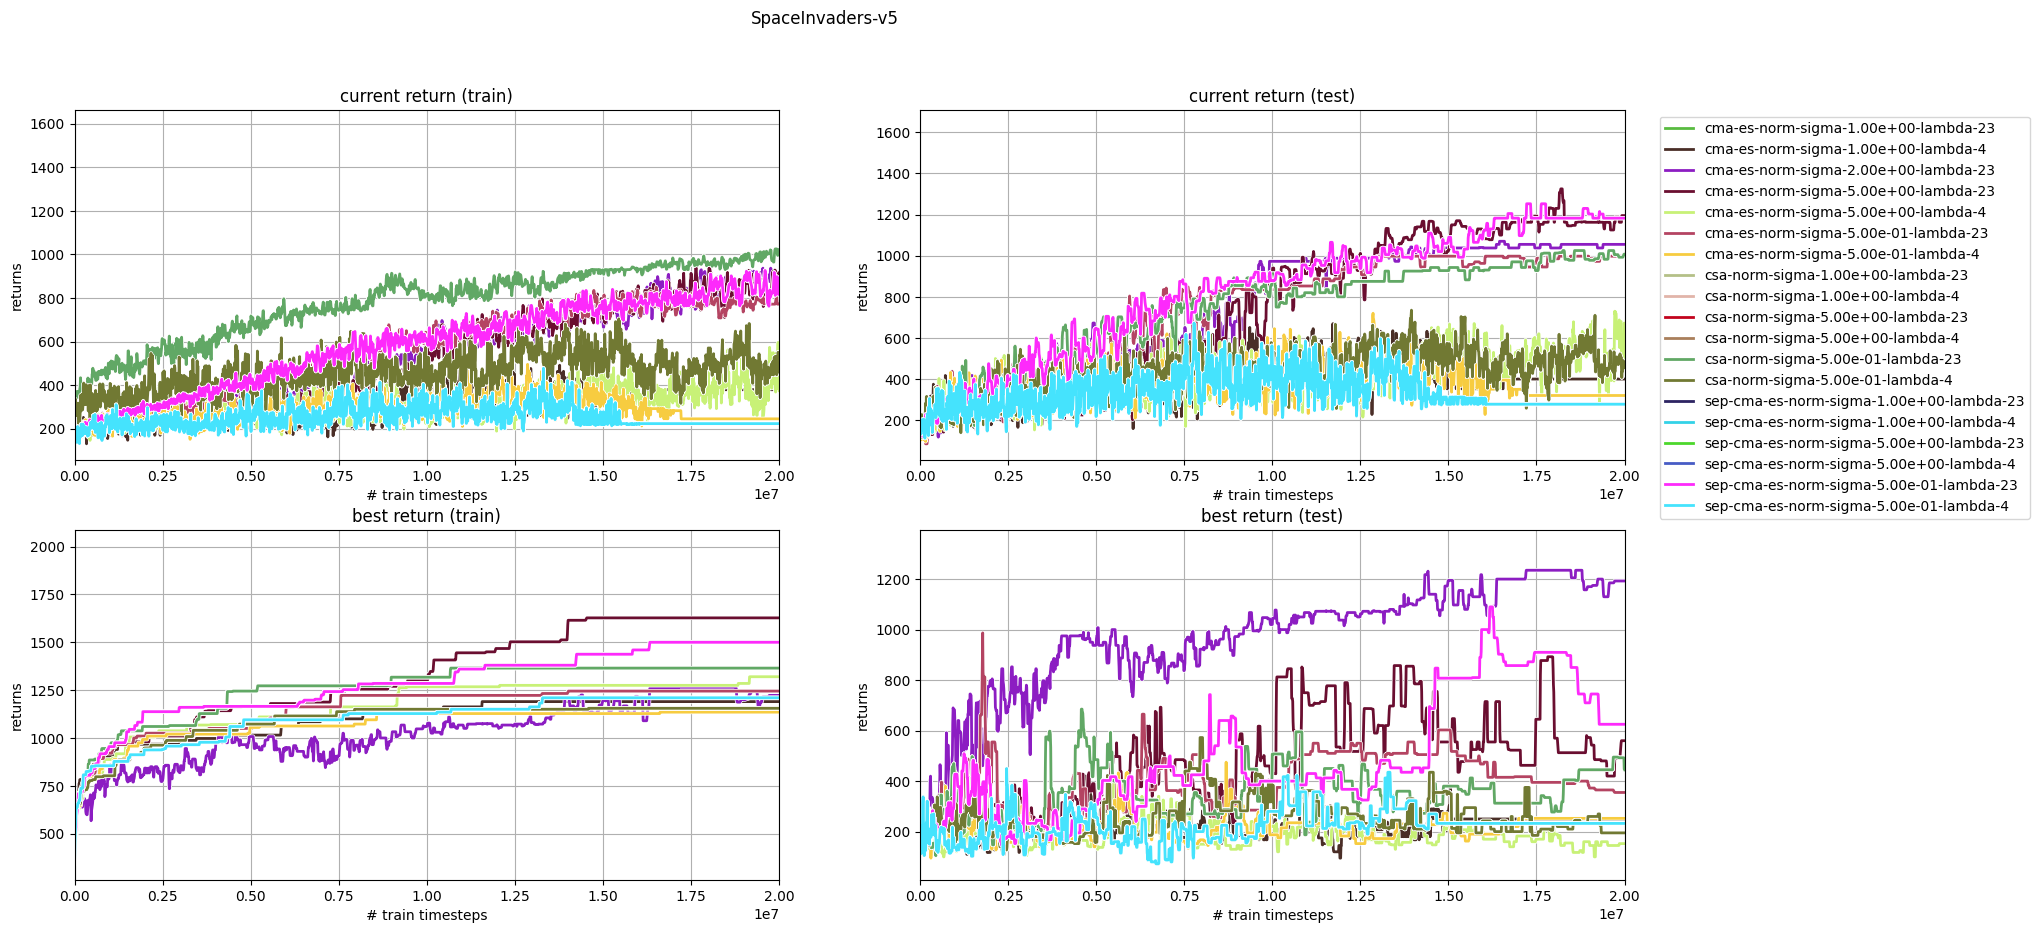

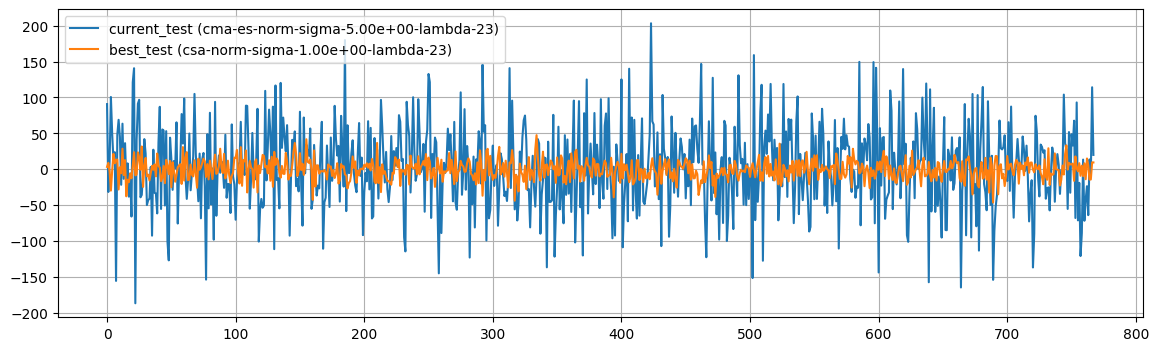

In [3]:
data = show_summary("data/SpaceInvaders-v5", xlim=2e7);

In [9]:
# data.groupby("strat")
data['test'] = data[['current_test', 'best_test']].max(axis=1)

data[data.n_train_timesteps < 1e7].groupby(["strat", "run"]).max("test").groupby("strat")['test'].describe()


count     mean           std  \
strat                                                                    
cma-es-norm-sigma-1.00e+00-lambda-22       10.0  71970.0  10388.139605   
cma-es-norm-sigma-1.00e+00-lambda-4        10.0  33730.0   7629.045375   
cma-es-norm-sigma-5.00e+00-lambda-22       10.0  73690.0   8786.157041   
cma-es-norm-sigma-5.00e+00-lambda-4        10.0  36440.0   8622.605948   
cma-es-norm-sigma-5.00e-01-lambda-22       10.0  71970.0  10388.139605   
cma-es-norm-sigma-5.00e-01-lambda-4        10.0  38750.0   5106.477368   
csa-norm-sigma-1.00e+00-lambda-22          10.0  71630.0  11595.406179   
csa-norm-sigma-1.00e+00-lambda-4           10.0  37920.0   8321.698545   
csa-norm-sigma-5.00e+00-lambda-22          10.0  71630.0  11595.406179   
csa-norm-sigma-5.00e+00-lambda-4           10.0  37920.0   8321.698545   
csa-norm-sigma-5.00e-01-lambda-22          10.0  71630.0  11595.406179   
csa-norm-sigma-5.00e-01-lambda-4           10.0  37920.0   8321.698545   
sep-cma-es-norm-sigma-1.00e+00-lambda-22   10.0  77020.0  14461.811781   
sep-cma-es-norm-sigma-1.00e+00-lambda-4    10.0  39320.0   8921.360135   
sep-cma-es-norm-sigma-5.00e+00-lambda-22   10.0  77020.0  14461.811781   
sep-cma-es-norm-sigma-5.00e+00-lambda-4    10.0  39320.0   8921.360135   
sep-cma-es-norm-sigma-5.00e-01-lambda-22   10.0  77020.0  14461.811781   
sep-cma-es-norm-sigma-5.00e-01-lambda-4    10.0  39320.0   8921.360135   

                                              min      25%      50%      75%  \
strat                                                                          
cma-es-norm-sigma-1.00e+00-lambda-22      59800.0  63425.0  71700.0  75600.0   
cma-es-norm-sigma-1.00e+00-lambda-4       22600.0  28775.0  32950.0  37950.0   
cma-es-norm-sigma-5.00e+00-lambda-22      55700.0  69450.0  75450.0  77725.0   
cma-es-norm-sigma-5.00e+00-lambda-4       26400.0  30775.0  34600.0  41475.0   
cma-es-norm-sigma-5.00e-01-lambda-22      59800.0  63425.0  71700.0  75600.0   
cma-es-norm-sigma-5.00e-01-lambda-4       32500.0  35225.0  38050.0  39850.0   
csa-norm-sigma-1.00e+00-lambda-22         55200.0  60650.0  74600.0  80025.0   
csa-norm-sigma-1.00e+00-lambda-4          25000.0  34150.0  37100.0  44825.0   
csa-norm-sigma-5.00e+00-lambda-22         55200.0  60650.0  74600.0  80025.0   
csa-norm-sigma-5.00e+00-lambda-4          25000.0  34150.0  37100.0  44825.0   
csa-norm-sigma-5.00e-01-lambda-22         55200.0  60650.0  74600.0  80025.0   
csa-norm-sigma-5.00e-01-lambda-4          25000.0  34150.0  37100.0  44825.0   
sep-cma-es-norm-sigma-1.00e+00-lambda-22  49100.0  69925.0  79600.0  86075.0   
sep-cma-es-norm-sigma-1.00e+00-lambda-4   28200.0  34100.0  39150.0  40500.0   
sep-cma-es-norm-sigma-5.00e+00-lambda-22  49100.0  69925.0  79600.0  86075.0   
sep-cma-es-norm-sigma-5.00e+00-lambda-4   28200.0  34100.0  39150.0  40500.0   
sep-cma-es-norm-sigma-5.00e-01-lambda-22  49100.0  69925.0  79600.0  86075.0   
sep-cma-es-norm-sigma-5.00e-01-lambda-4   28200.0  34100.0  39150.0  40500.0   

                                              max  
strat                                              
cma-es-norm-sigma-1.00e+00-lambda-22      90000.0  
cma-es-norm-sigma-1.00e+00-lambda-4       49100.0  
cma-es-norm-sigma-5.00e+00-lambda-22      89500.0  
cma-es-norm-sigma-5.00e+00-lambda-4       54400.0  
cma-es-norm-sigma-5.00e-01-lambda-22      90000.0  
cma-es-norm-sigma-5.00e-01-lambda-4       49100.0  
csa-norm-sigma-1.00e+00-lambda-22         85700.0  
csa-norm-sigma-1.00e+00-lambda-4          49300.0  
csa-norm-sigma-5.00e+00-lambda-22         85700.0  
csa-norm-sigma-5.00e+00-lambda-4          49300.0  
csa-norm-sigma-5.00e-01-lambda-22         85700.0  
csa-norm-sigma-5.00e-01-lambda-4          49300.0  
sep-cma-es-norm-sigma-1.00e+00-lambda-22  97600.0  
sep-cma-es-norm-sigma-1.00e+00-lambda-4   55700.0  
sep-cma-es-norm-sigma-5.00e+00-lambda-22  97600.0  
sep-cma-es-norm-sigma-5.00e+00-lambda-4   55700.0  
sep-cma-es-norm-sigma-5.

In [94]:
data.groupby(["strat", "run"]).max("n_evals").groupby("strat")['n_evals'].describe()

count     mean          std      min  \
strat                                                                        
cma-es-norm-sigma-1.00e+00-lambda-4    10.0   1351.6    39.975548   1276.0   
cma-es-norm-sigma-5.00e+00-lambda-23   10.0  15038.4  1704.176517  12432.0   
cma-es-norm-sigma-5.00e+00-lambda-4    10.0  42020.8  4264.713219  35108.0   
csa-norm-sigma-1.00e+00-lambda-23      10.0  49615.2   851.768983  47784.0   
csa-norm-sigma-1.00e+00-lambda-4       10.0  46158.8  4089.537458  38476.0   
csa-norm-sigma-5.00e+00-lambda-23      10.0  49624.8   833.233701  47808.0   
csa-norm-sigma-5.00e+00-lambda-4       10.0  46410.8  4440.573356  37132.0   
csa-norm-sigma-5.00e-01-lambda-23      10.0  49452.0  1192.040268  47016.0   
csa-norm-sigma-5.00e-01-lambda-4       10.0  45981.6  4525.335769  37416.0   

                                          25%      50%      75%      max  
strat                                                                     
cma-es-norm-sigma-1.00e+00-lambda-4    1326.0   1364.0   1375.0   1404.0  
cma-es-norm-sigma-5.00e+00-lambda-23  13734.0  15264.0  16068.0  17904.0  
cma-es-norm-sigma-5.00e+00-lambda-4   38748.0  43606.0  45539.0  46796.0  
csa-norm-sigma-1.00e+00-lambda-23     50016.0  50016.0  50016.0  50016.0  
csa-norm-sigma-1.00e+00-lambda-4      43721.0  47008.0  49616.0  50000.0  
csa-norm-sigma-5.00e+00-lambda-23     50016.0  50016.0  50016.0  50016.0  
csa-norm-sigma-5.00e+00-lambda-4      43674.0  48082.0  50000.0  50000.0  
csa-norm-sigma-5.00e-01-lambda-23     50016.0  50016.0  50016.0  50016.0  
csa-norm-sigma-5.00e-01-lambda-4      43379.0  47136.0  49908.0  50000.0

strat              folder generation  \
2628  cma-es-norm-sigma-1.00e-01-lambda-17  1702842403.4093606        405   

     n_train_episodes n_train_timesteps current_test  
2628             7290           7290000  6571.798297

strat              folder generation  \
130474  csa-norm-sigma-1.00e-02-lambda-17  1702839877.3152547        515   

       n_train_episodes n_train_timesteps    best_test  
130474             9270           9270000  6586.153651

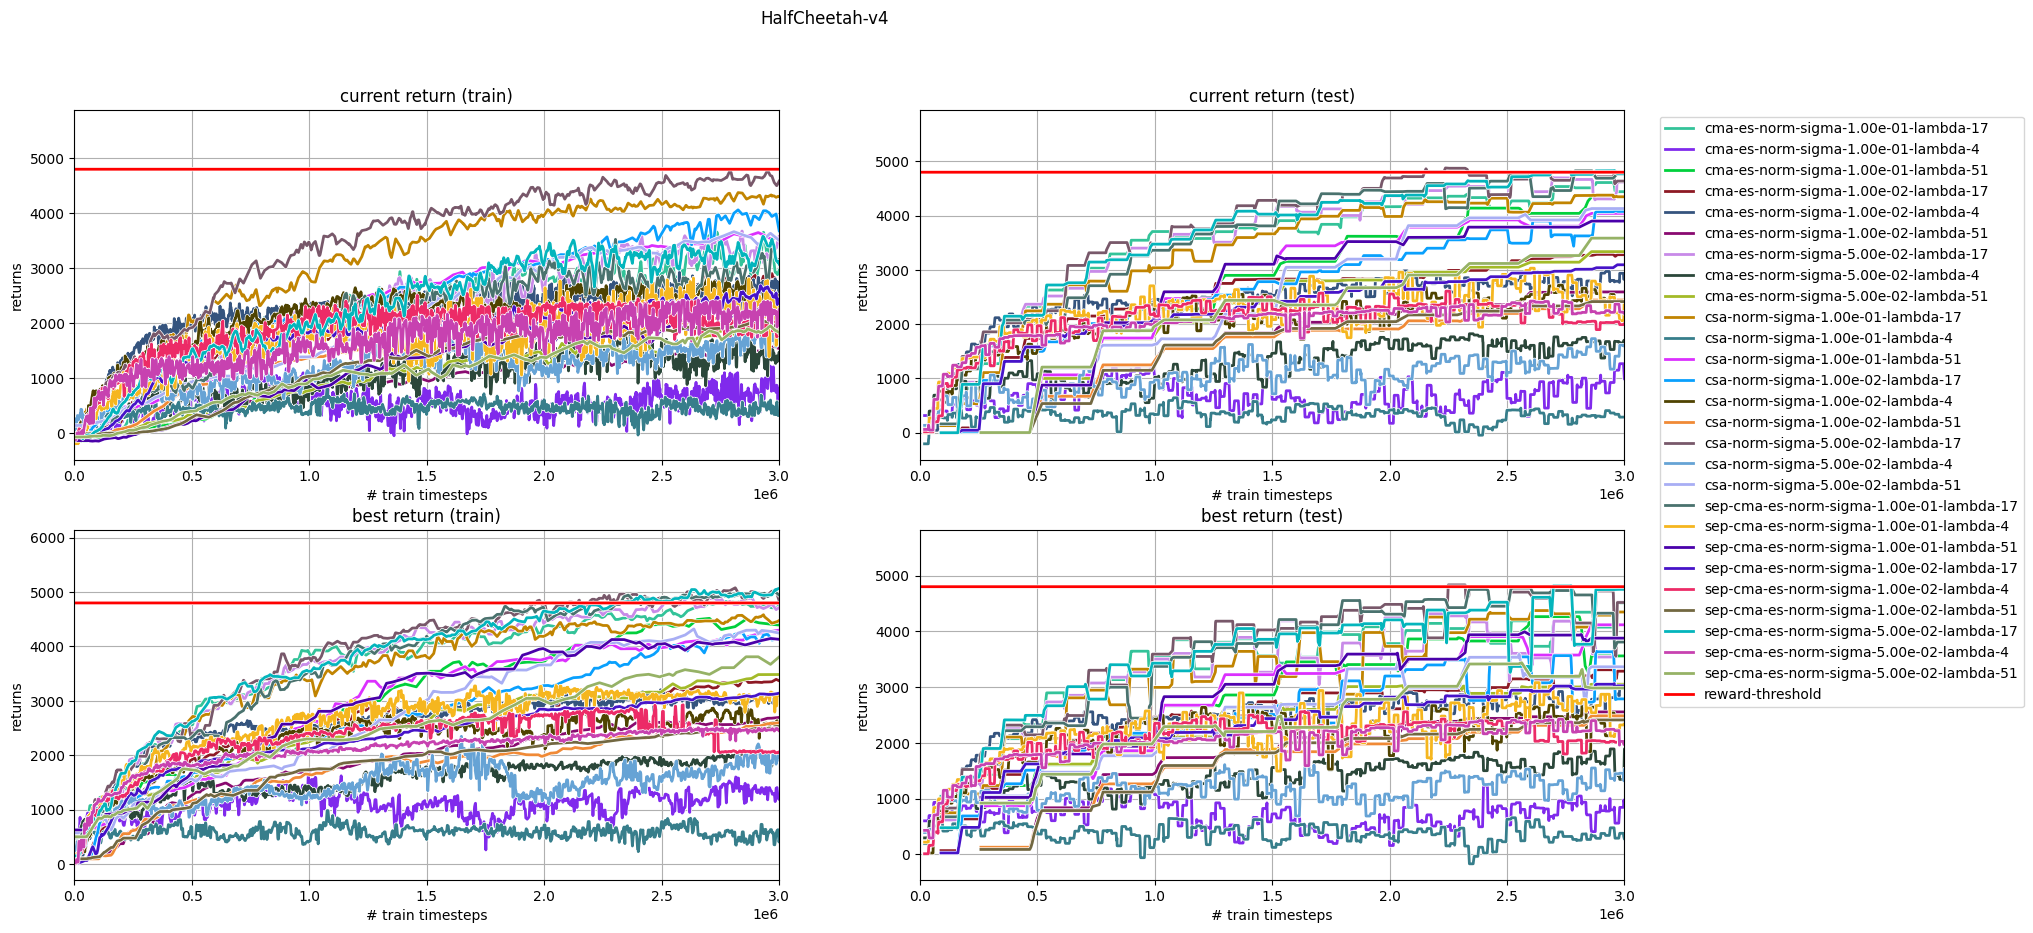

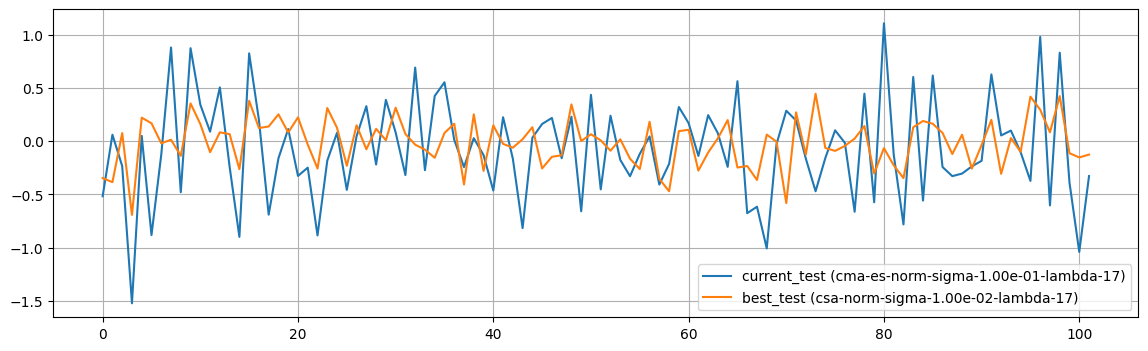

In [8]:
show_summary("data/HalfCheetah-v4/", xlim=3e6);

strat             folder generation  \
227119  csa-norm-sigma-1.00e-01-lambda-32  1702859854.337819        585   

       n_train_episodes n_train_timesteps current_test  
227119            18720          13682994  2750.754708

strat             folder generation  \
227159  csa-norm-sigma-1.00e-01-lambda-32  1702859854.337819        625   

       n_train_episodes n_train_timesteps    best_test  
227159            20000          14750509  2744.279887

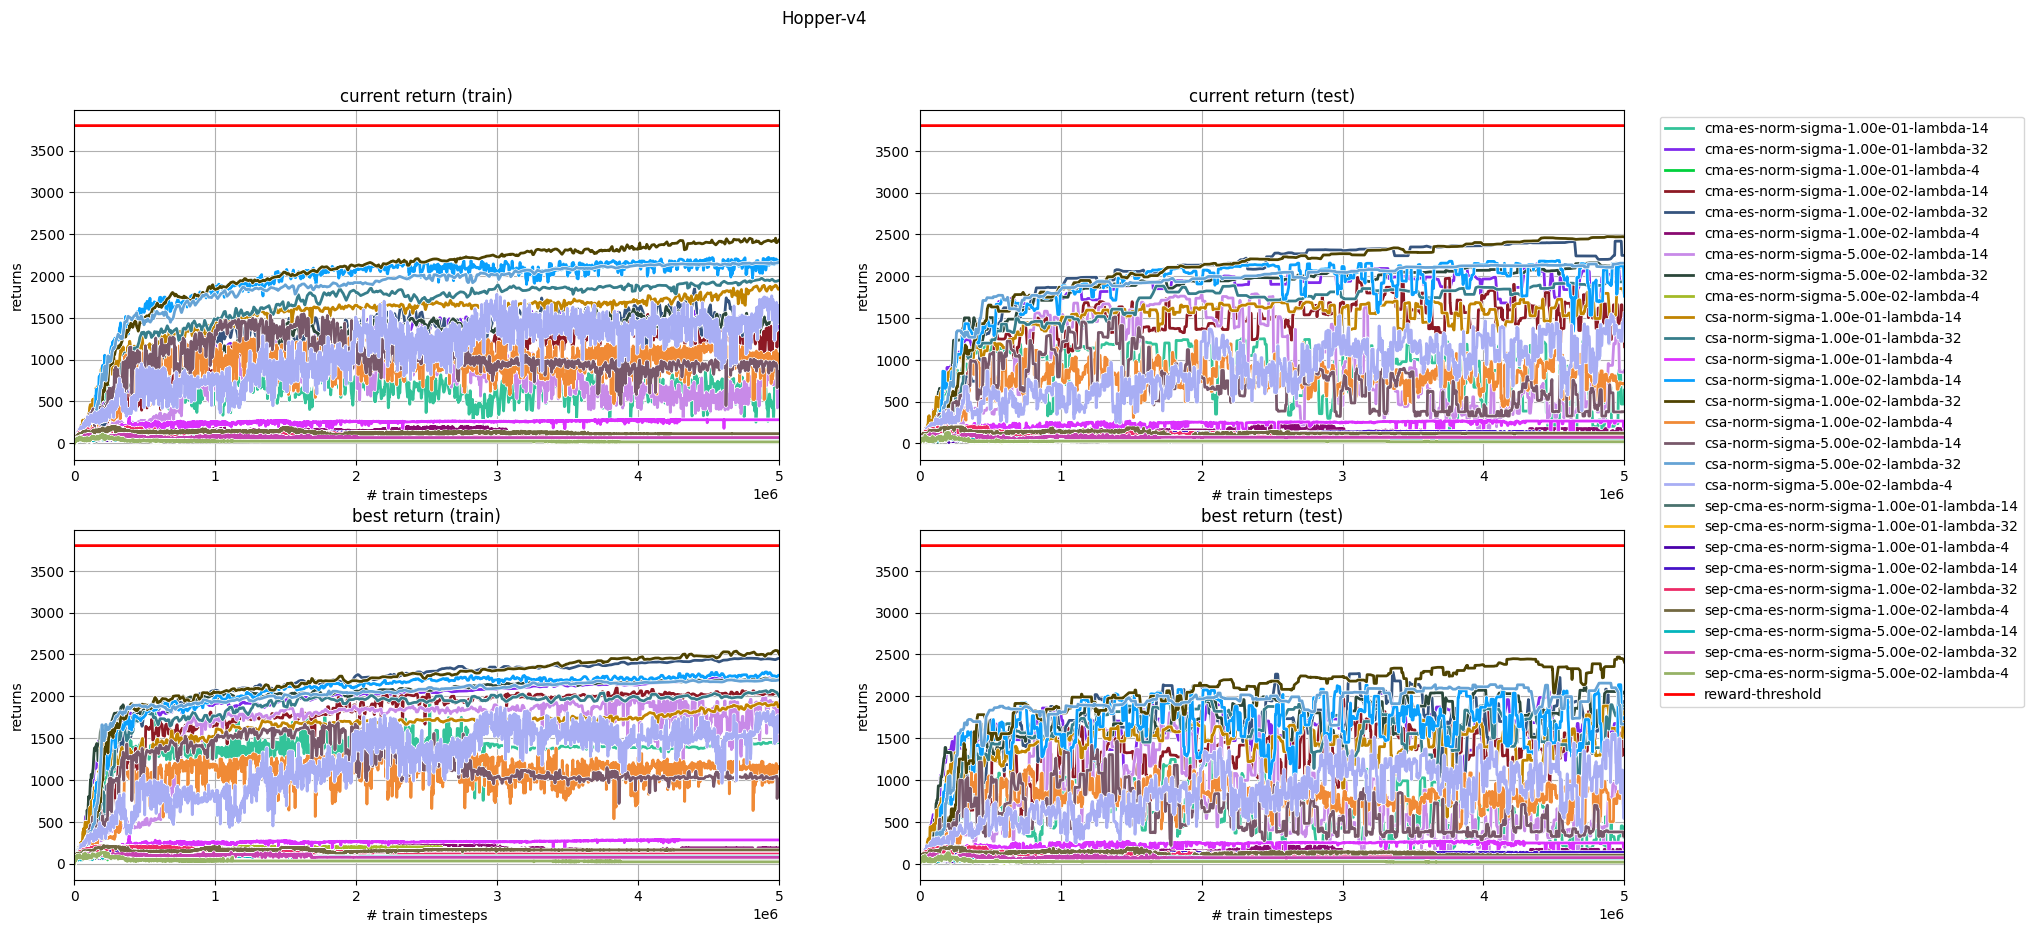

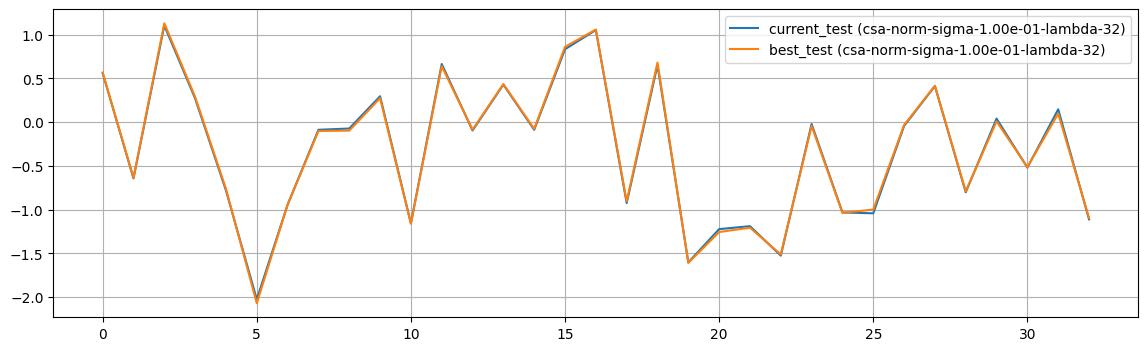

In [12]:
show_summary("data/Hopper-v4/", xlim=5e6); 

strat              folder generation  \
640939  csa-norm-sigma-1.00e-01-lambda-51  1702876585.0371494        960   

       n_train_episodes n_train_timesteps current_test  
640939            49920          20651957  3566.257865

strat              folder generation  \
640574  csa-norm-sigma-1.00e-01-lambda-51  1702876585.0371494        595   

       n_train_episodes n_train_timesteps    best_test  
640574            30940          10577693  3533.187133

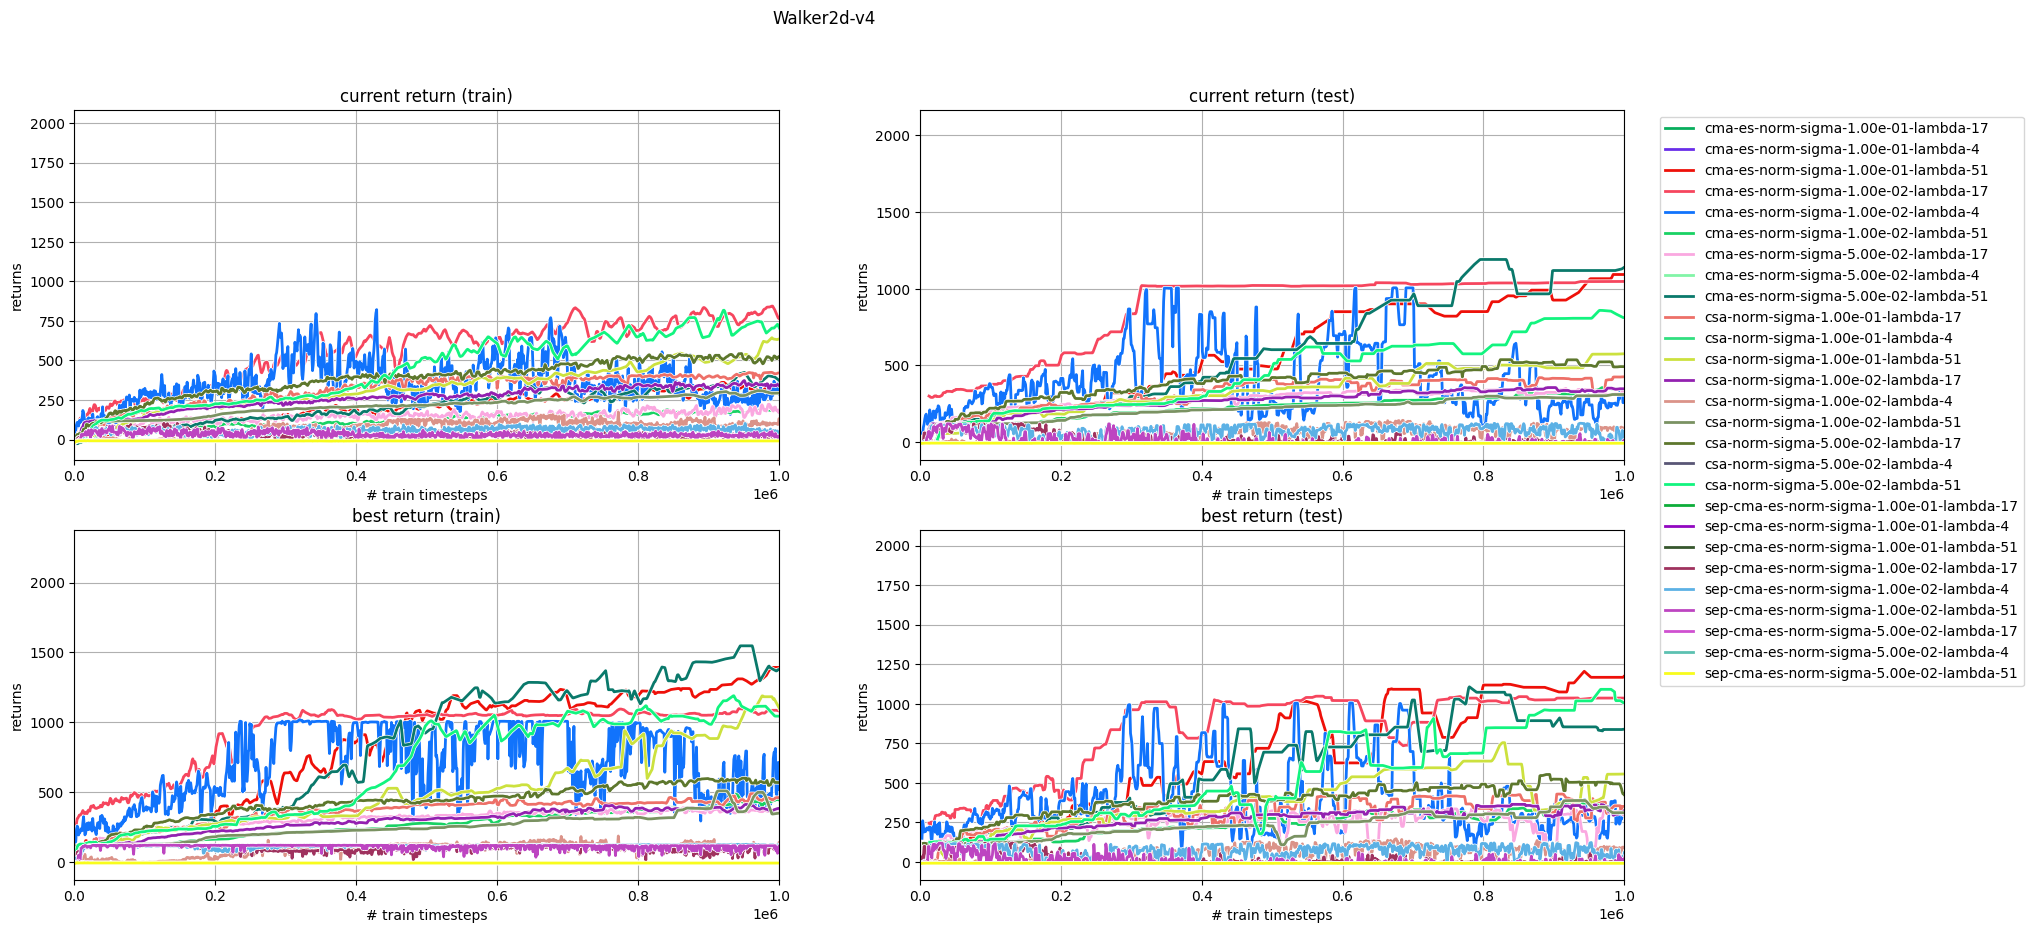

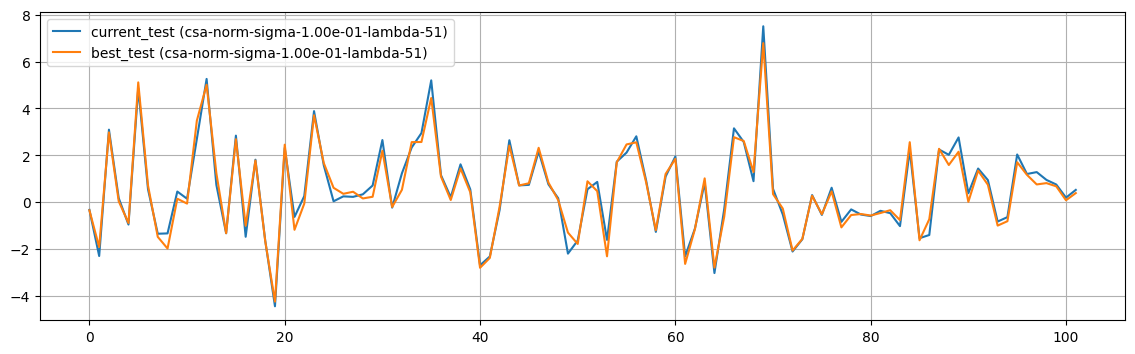

strat             folder generation  \
28214  csa-norm-sigma-1.00e-02-lambda-17  1704893396.265467       1265   

      n_train_episodes n_train_timesteps current_test  
28214            22770           8718295  3064.890473

python main.py --env= --play=data/Walker2d-v4//csa-norm-sigma-1.00e-02-lambda-17/1704893396.265467/policies/t-1265-mean
code data/Walker2d-v4//csa-norm-sigma-1.00e-02-lambda-17/1704893396.265467/policies/videos/test-episode-0.mp4


strat             folder generation  \
28209  csa-norm-sigma-1.00e-02-lambda-17  1704893396.265467       1260   

      n_train_episodes n_train_timesteps    best_test  
28209            22680           8668461  3042.389128

python main.py --env= --play=data/Walker2d-v4//csa-norm-sigma-1.00e-02-lambda-17/1704893396.265467/policies/t-1260-best
code data/Walker2d-v4//csa-norm-sigma-1.00e-02-lambda-17/1704893396.265467/policies/videos/test-episode-0.mp4


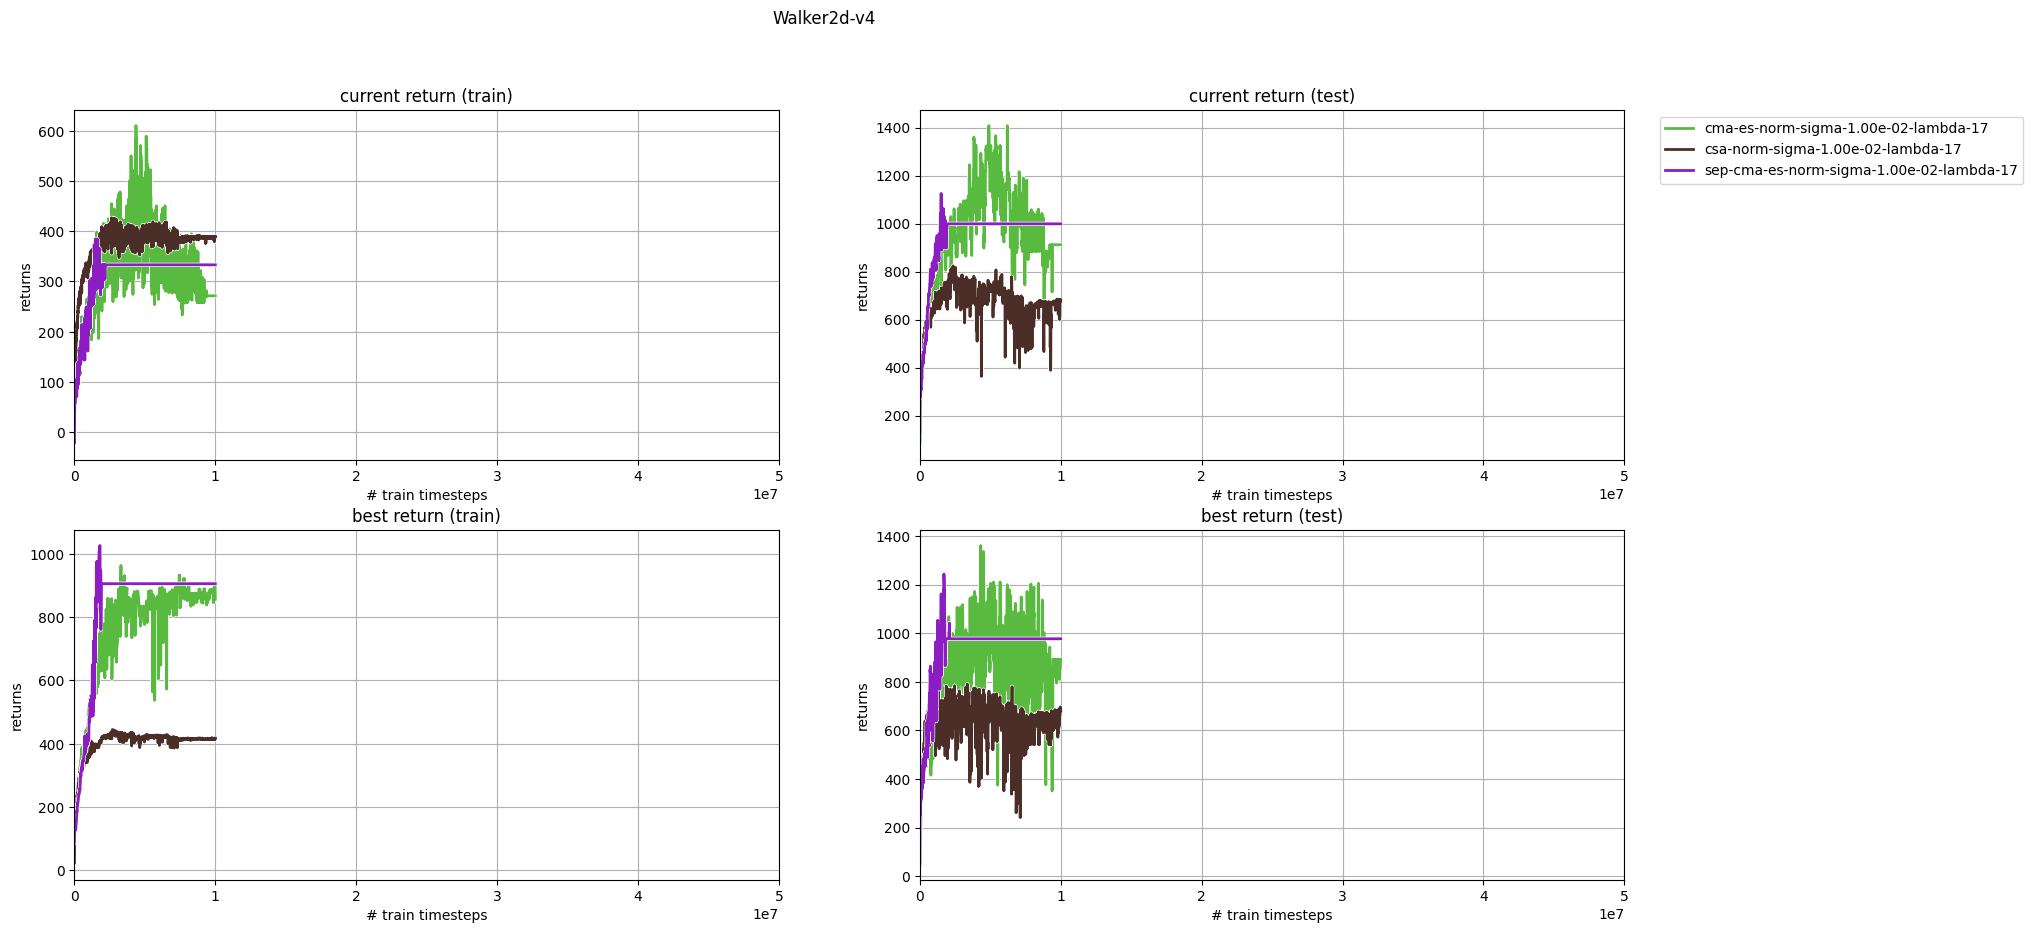

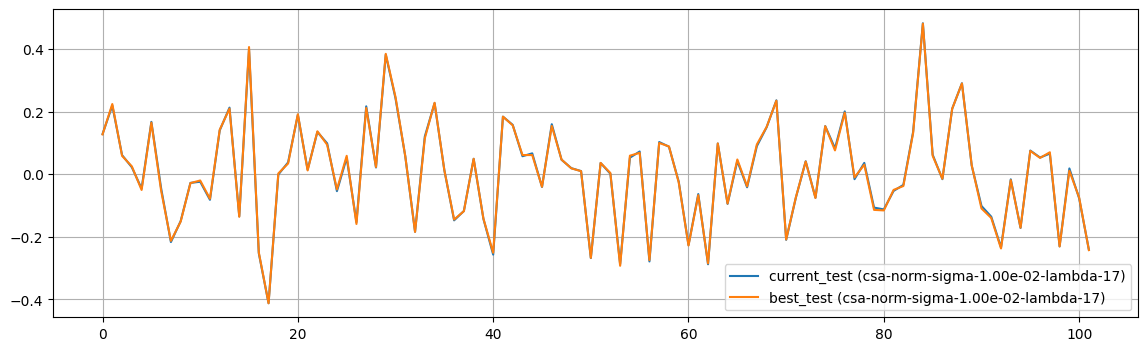

In [67]:
show_summary("data/Walker2d-v4/", xlim=5e7);

In [110]:
data = []
for name, setting in ENVIRONMENTS.items():
    n = 128 * setting.action_size
    if not 'v5' in name: continue
    data.append([name, 128, setting.action_size, n])
    # print(f"{name:20s} {str(n):5s} {1 / np.sqrt(n):.5f} {1/n:.5f}")   

pd.DataFrame( 
    sorted(data, key=lambda x:x[0][-1]), 
    columns=["Environment", "State Size", "Action Size", "Total Weights"]
).describe()

State Size  Action Size  Total Weights
count        12.0    12.000000      12.000000
mean        128.0     8.500000    1088.000000
std           0.0     4.757769     608.994402
min         128.0     4.000000     512.000000
25%         128.0     6.000000     768.000000
50%         128.0     6.500000     832.000000
75%         128.0     9.000000    1152.000000
max         128.0    18.000000    2304.000000

2304

In [7]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from bokeh.models import Div, HoverTool
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [8]:
root = "data/Experiments_RL_ES"
data = []
for r in os.listdir(root):
    r = os.path.join(root, r)
    for folder in os.listdir(r):
        f = os.path.join(r, folder)
        stats = pd.read_csv(os.path.join(f, "rewards.csv"))
        with open(os.path.join(f, "args.json")) as h:
            meta = json.load(h)
            stats['total_timesteps'] = meta['total_timesteps']
            stats['env'] = meta['env']
            stats['exp_name'] = f"{meta['exp_name']}_{meta['network_size']}"
            stats = stats.drop(stats.columns[0], axis=1)
            data.append(stats)
data = pd.concat(data)

In [10]:
def load_data(env_folder):
    stats_list = []
    for strat, color in zip(os.listdir(env_folder), colors.TABLEAU_COLORS):
        for i, (run) in enumerate(os.listdir(os.path.join(env_folder, strat))):
            path = os.path.join(env_folder, strat, run)
            stats = pd.read_csv(os.path.join(path, "stats.csv"), skipinitialspace=True)
            if len(stats) == 0: continue
            stats['run'] = i
            stats['folder'] = run
            stats['strat'] = strat
            with open(os.path.join(path, "settings.json")) as f:
                meta = json.load(f)
            stats['env'] = meta['env_name']    
            stats_list.append(stats)
    return pd.concat(stats_list, ignore_index=True)

def plot_es(env, ax1, ax2):
    if not os.path.isdir(f"data/{env}"):
        if os.path.isdir(f"data/old-21-nov/{env}"):
            data = load_data(f"data/old-21-nov/{env}")
        elif os.path.isdir(f"data/old-5-dec/{env}"):
            data = load_data(f"data/old-5-dec/{env}")
        else:
            return 0
    else:    
        data = load_data(f"data/{env}")

    

    xmax = data.groupby("strat")['n_train_timesteps'].max().median()
    time = np.linspace(0, xmax, 1000)
    
    stats = dict()
    for (strat, strat_data), color in zip(data.groupby("strat"), colors.TABLEAU_COLORS.values()):
        # mean_train = []
        mean_test = []
        # if not "ars" in strat and not "egs" in strat: continue
        best_train = []
        best_test = []
        for run, run_data in strat_data.groupby("run"):
            idx = ~np.isnan(run_data.current_test)
            # mean_train.append(np.interp(time, run_data.n_train_timesteps, run_data.current))
            mean_test.append(np.interp(time, run_data.n_train_timesteps[idx], run_data.current_test[idx]))
            # best_train.append(np.interp(time, run_data.n_train_timesteps, run_data.best))
            best_test.append(np.interp(time, run_data.n_train_timesteps[idx], run_data.best_test[idx]))

        strat, *_ = strat.split("-norm")
        
        mean_line = geo_mean(mean_test)
        best_line = geo_mean(best_test)
        line = best_line.copy() #np.maximum(mean_line, best_line)
        r1 = p1.line(x=time, y=line, legend_label=strat, name=strat, color=color)
        
        
        line = np.vstack([mean_test, best_test])
        line = np.max(line, axis=0)
        stats[strat] = dict(
            median=np.median(line),
            mean=np.mean(line),
            std=np.std(line),
            max=np.max(line),
            min=np.min(line),
            tmax=xmax
        ).copy()
        # r1 = p1.line(x=time, y=geo_mean(mean_test), legend_label=strat, name=strat, color=color)
        # r2 = p2.line(x=time, y=geo_mean(best_test), legend_label=strat, name=strat, color=color)

    return xmax, stats
    
c = list(colors.CSS4_COLORS.values())
np.random.seed(105)
np.random.shuffle(c)


stats = dict()
for env, group in data.groupby("env"):
    if not os.path.isdir(f"data/{env}") and not os.path.isdir(f"data/old-21-nov/{env}") and not os.path.isdir(f"data/old-5-dec/{env}"): continue
    # if not env == "LunarLander-v2": continue
    
    hover = HoverTool(tooltips=[
        ("index", "$index"),
        ("(x,y)", "(@x, @y)"),
        ('name', '$name'),
    ])
    p1 = figure(width = 1000, height=500, tools=[hover])#, title="median test (current)")
    p2 = None #figure(width = 1000, height=500, tools=[hover], title="median test (best)")
    xmax, env_stats = plot_es(env, p1, p2)   

    time = None
    for (exp, exp_data), color in zip(group.groupby("exp_name"), c):
        mean_train = []
        mean_test = []
        for run, run_data in exp_data.groupby("run"):
            if time is None:
                time = np.linspace(0, max(run_data.total_timesteps), 1000)

            idx = ~np.isnan(run_data.test_reward_mean)
            
            mean_train.append(np.interp(time, run_data.timesteps, run_data.train_reward))
            mean_test.append(np.interp(time, run_data.timesteps[idx], run_data.test_reward_mean[idx]))

        r1 = p1.line(x=time, y=geo_mean(mean_test), name=exp, legend_label=exp, color=color)
        # r2 = p2.line(x=time, y=geo_mean(mean_test), name=exp, legend_label=exp, color=color)
        line = np.max(mean_test, axis=0)
        env_stats[exp] = dict(
            median=np.median(line),
            mean=np.mean(line),
            std=np.std(line),
            max=np.max(line),
            min=np.min(line),
            tmax=time[-1]
        )
    stats[env] = env_stats
    
    thres = gym.make(env).spec.reward_threshold
    for p in p1,:#, p2:
        if thres:
            xmax = max(xmax, time[-1])
            p.line(x=[0, xmax], y=np.ones(2) * thres, name="reward-threshold", legend_label="reward-threshold", color="red")
        p.legend.click_policy="hide"
        p.legend.location = "bottom_right"
        p.xaxis.axis_label = 'timesteps'
        p.yaxis.axis_label = 'returns'
    
    t = show(column(Div(text=f"<h1>{env}</h1>"), row(p1)), notebook_handle=True)
    


In [ ]:
for env_name, env_stats in stats.items():
    if env_name in ("Acrobot-v1", "LunarLander-v2", "BipedalWalker-v3"): continue
    display(env_name)
    display(pd.DataFrame(env_stats).drop(["min", ]))


NameError: name 'stats' is not defined

In [34]:
from objective import uint8tofloat

def get_non_zero_ram_idx(env, n_reps=100):
    observations = []
    for _ in range(n_reps):
        obs, *_ = env.reset()
        done = False
        while not done:
            observations.append(obs)
            action = env.action_space.sample()
            obs, reward, done, trunc, info = env.step(action)

    observations = np.vstack(observations)
    std_dev = observations.std(axis=0)
    plt.plot(observations.std(axis=0))
    non_zero_std_idx = np.where(std_dev != 0)[0]
    print("number of non zero std ram bytes", non_zero_std_idx.shape)
    return non_zero_std_idx


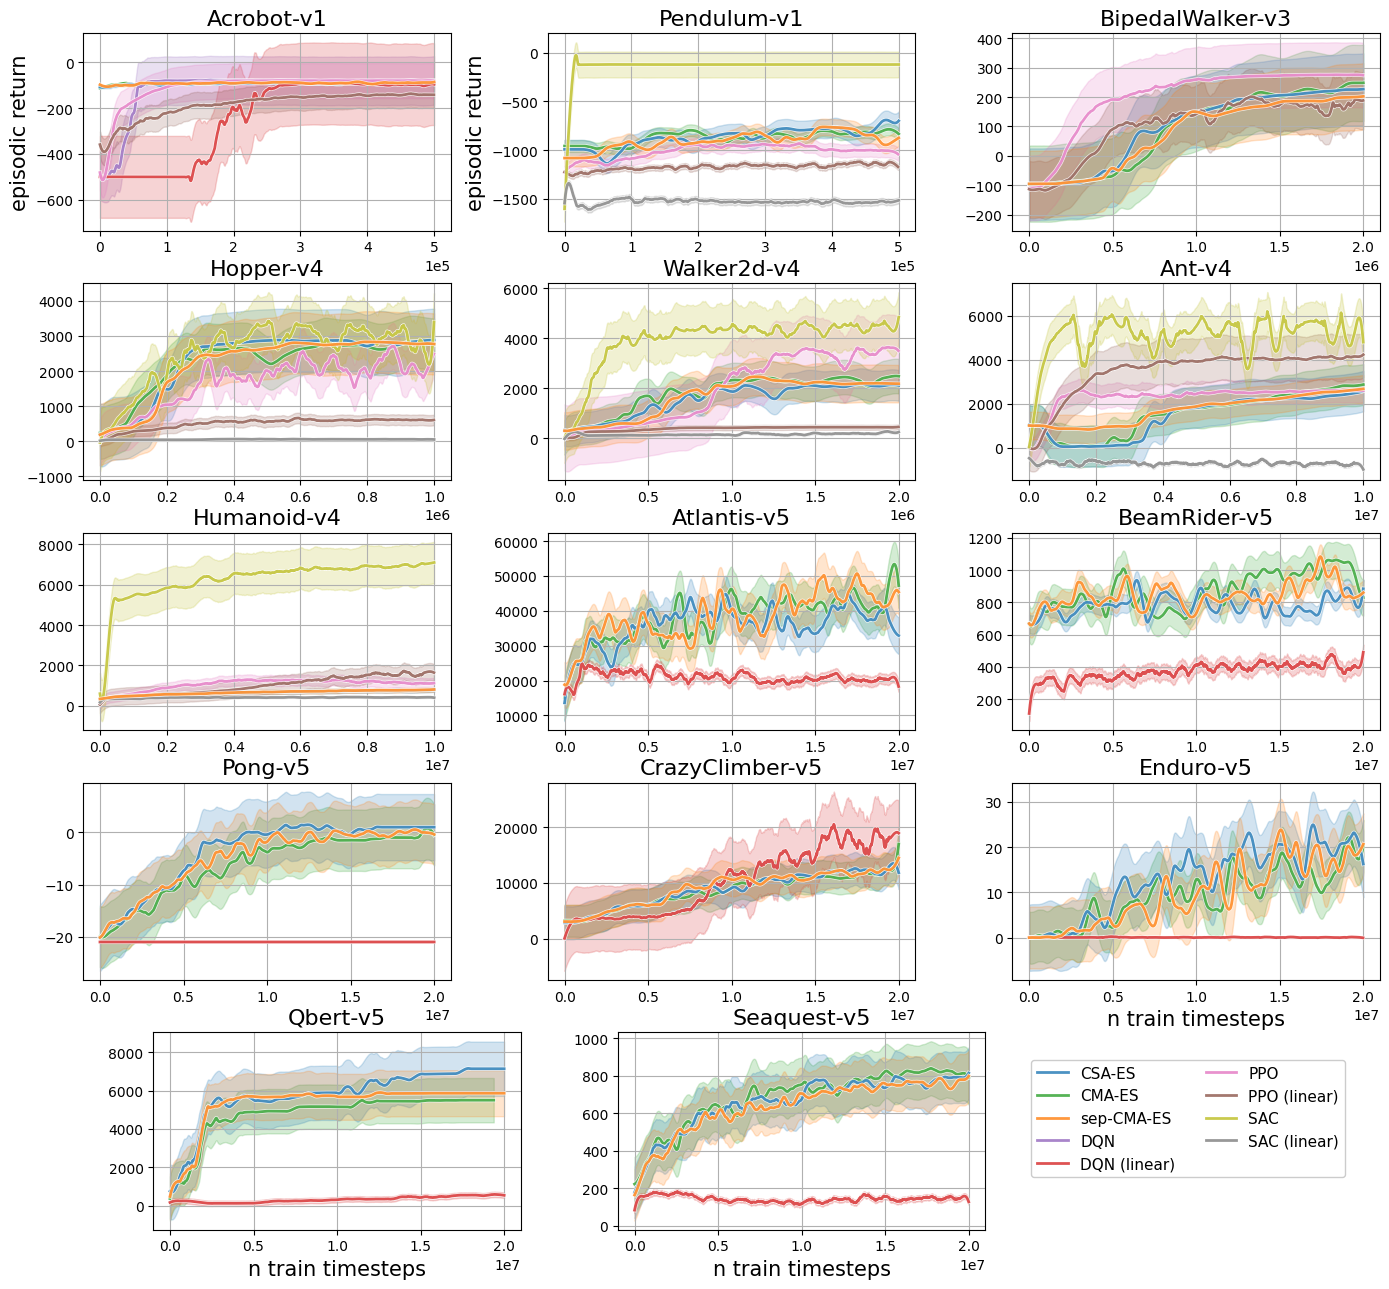

In [4]:
time_measure = 'n_train_timesteps'
max_reward = pd.DataFrame()
rl_data = pd.read_pickle(f"data/rl_data2.pkl")
# rl_data = rl_data[rl_data.method.str.endswith("small")]

col = {x:y for x, y in zip(
    (
        "csa", 
        "sep-cma-es",
        "cma-es",
        "dqn_small",
        "dqn_large",
        "ppo_small",
        "ppo_large",
        "sac_small",
        "sac_large",
     )
    , colors.TABLEAU_COLORS.keys())}

bounds = {
    "CartPole-v1": (0, 500)
}

def get_bounds(name):
    if b:=bounds.get(name):
        return b
    lb, ub = -np.inf, np.inf        
    return lb, ub

def pretty(label):
    return (label
            .replace("_large", "")
            .replace("csa", "csa-es")
            .upper() 
            .replace("_SMALL", " (linear)")
            .replace("SEP-", "sep-")
           )
    
f, axes = plt.subplots(5, 3, figsize=(14, 13))

f.delaxes(axes.ravel()[-1])

from scipy.signal import savgol_filter
summary = pd.DataFrame()
handles, labels = [], []
for i, ((env_name, min_timesteps), ax) in enumerate(zip((
    # ("CartPole-v1", 5e5),
    # ("LunarLander-v2", 5e5),
    # ("Swimmer-v4", 5e5),
    # ("HalfCheetah-v4", 3e6),
    # # ("Boxing-v5", 1e8),
    # ("SpaceInvaders-v5", 1e8),
    
    ("Acrobot-v1", 5e5),
    ("Pendulum-v1", 5e5),
    ("BipedalWalker-v3", 2e6),
    
    ("Hopper-v4", 1e6),
    ("Walker2d-v4", 2e6),
    ("Ant-v4", 1e7),
    ("Humanoid-v4", 1e7),
    
    ("Atlantis-v5", 2e7),
    ("BeamRider-v5", 2e7),
    ("Pong-v5", 2e7),
    ("CrazyClimber-v5", 2e7),
    ("Enduro-v5",  2e7),
    
    ("Qbert-v5", 2e7),
    ("Seaquest-v5", 2e7),
), axes.ravel())):
    # print(env_name)
    data = rl_data[rl_data.env == env_name.split("-test")[0]]
    if env_name == "BipedalWalker-v3":
        data = data[data.method.str.startswith("ppo")]
    try: 
        data = pd.concat([data, pd.read_pickle(f"data/{env_name}/data_hyp.pkl")])
    except:
        data = pd.concat([data, pd.read_pickle(f"data/{env_name}/data.pkl")])
        # print(data.groupby(["method"])[['sigma0', 'lambda']].max() )
        
    env_name = env_name.split("-test")[0]
    # data['env'] = env_name
    for label, group in data.groupby("method"):
        time = np.linspace(0, min(min_timesteps, group[time_measure].max()), 1000)
        line = []
        for _, run in group.groupby("run"):
            line.append(np.interp(time, run[time_measure], run.test))

        line = savgol_filter(np.median(line, axis=0), 51, 3)
                
        std = np.std(line, axis=0)

        lb, ub = get_bounds(env_name)
        
        p = ax.fill_between(time, np.maximum(line - std, lb), np.minimum(ub, line + std), alpha=.2, color=col[label])
        ax.plot(time, line, linewidth=3, color="white", alpha=.8)

        ax.plot(time, line, linewidth=2, color=p.get_facecolor()[0][:3], label=pretty(label), alpha=.8)

        
    asummary = data[data.n_train_timesteps < min_timesteps].groupby(["run", "method"])['test'].max().groupby("method").describe()
    
    asummary['env'] = env_name
    asummary['n_timesteps'] = min_timesteps
    summary = pd.concat([summary, asummary])
    ax.set_title(env_name, fontsize=16)
    ax.grid()
    

    if i in {0, 1}:
        ax.set_ylabel("episodic return", fontsize=15)
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if i > 10:
        ax.set_xlabel(' '.join(time_measure.split("_")), fontsize=15)

    for h, l in zip(*ax.get_legend_handles_labels()):
        if l in labels: continue
        handles.append(h)
        labels.append(l)
    

es = {
     'CMA-ES': 2,
     'CSA-ES': 1,
     'sep-CMA-ES': 3
}



order = sorted(range(len(labels)), key=lambda x: es.get(labels[x]) or 4)
plt.tight_layout(h_pad=-1.)
ax.legend(
    [handles[idx] for idx in order], 
    [labels[idx] for idx in order], 
    ncol=2, 
    bbox_to_anchor=(2., .9),
    fancybox=True, 
    framealpha=1,
    fontsize=11
)     

xshift = .05
yshift = .0
for ax in axes.ravel()[-3:]:
    box = ax.get_position()
    box.x0 = box.x0 + xshift
    box.x1 = box.x1 + xshift
    box.y0 = box.y0 - yshift
    box.y1 = box.y1 - yshift
    ax.set_position(box)

In [8]:
summary

count         mean          std     min       25%      50%  \
method                                                                   
cma-es       10.0   -73.150000     6.169144   -84.0   -76.750   -70.25   
csa          10.0   -75.200000     2.496664   -80.5   -75.500   -74.75   
dqn_large    10.0   -65.100000     3.238655   -69.0   -67.875   -65.50   
dqn_small    10.0   -76.950000    14.442318  -113.0   -71.375   -70.75   
ppo_large    13.0   -69.615385     1.894662   -71.5   -70.500   -70.00   
...           ...          ...          ...     ...       ...      ...   
sep-cma-es   10.0  7385.000000  3384.260957  1575.0  4887.500  7512.50   
cma-es       10.0   916.000000   104.902071   840.0   860.000   870.00   
csa          10.0   939.000000   212.835356   780.0   840.000   840.00   
dqn_small     5.0   644.000000    35.777088   600.0   620.000   640.00   
sep-cma-es   10.0   946.000000   149.681143   780.0   850.000   910.00   

                 75%      max          env  n_timesteps  
method                                                   
cma-es       -69.250    -65.0   Acrobot-v1     500000.0  
csa          -74.000    -71.5   Acrobot-v1     500000.0  
dqn_large    -62.000    -61.0   Acrobot-v1     500000.0  
dqn_small    -70.125    -69.5   Acrobot-v1     500000.0  
ppo_large    -69.500    -64.0   Acrobot-v1     500000.0  
...              ...      ...          ...          ...  
sep-cma-es  9956.250  12500.0     Qbert-v5   20000000.0  
cma-es       910.000   1120.0  Seaquest-v5   20000000.0  
csa          930.000   1470.0  Seaquest-v5   20000000.0  
dqn_small    680.000    680.0  Seaquest-v5   20000000.0  
sep-cma-es   995.000   1300.0  Seaquest-v5   20000000.0  

[76 rows x 10 columns]

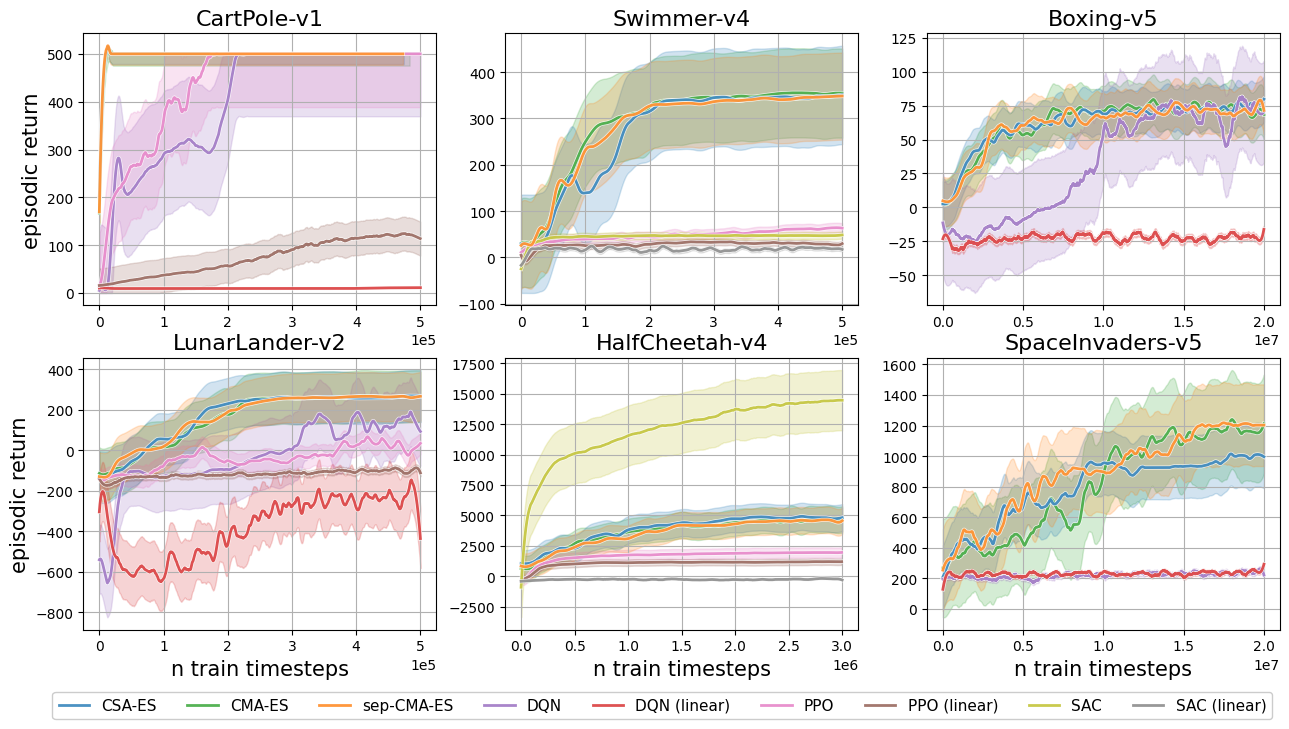

In [10]:
time_measure = 'n_train_timesteps'
max_reward = pd.DataFrame()

col = {x:y for x, y in zip(
    (
        "csa", 
        "sep-cma-es",
        "cma-es",
        "dqn_small",
        "dqn_large",
        "ppo_small",
        "ppo_large",
        "sac_small",
        "sac_large",
     )
    , colors.TABLEAU_COLORS.keys())}

bounds = {
    "CartPole-v1": (0, 500)
}

def get_bounds(name):
    if b:=bounds.get(name):
        return b
    lb, ub = -np.inf, np.inf        
    return lb, ub

def pretty(label):
    return (label
            .replace("_large", "")
            .replace("csa", "csa-es")
            .upper() 
            .replace("_SMALL", " (linear)")
            .replace("SEP-", "sep-")
           )
    
f, axes = plt.subplots(2, 3, figsize=(13, 7))


from scipy.signal import savgol_filter
summary = pd.DataFrame()
handles, labels = [], []
for i, ((env_name, min_timesteps), ax) in enumerate(zip((
    ("CartPole-v1", 5e5),
    ("LunarLander-v2", 5e5),
    ("Swimmer-v4", 5e5),
    ("HalfCheetah-v4", 3e6),
    ("Boxing-v5", 2e7),
    ("SpaceInvaders-v5", 2e7),
), axes.T.ravel())):
    # print(env_name)
    data = rl_data[rl_data.env == env_name]
    try: 
        data = pd.concat([data, pd.read_pickle(f"data/{env_name}/data_hyp.pkl")])
    except:
        # continue
        data = pd.concat([data, pd.read_pickle(f"data/{env_name}/data.pkl")])
    
    for label, group in data.groupby("method"):
        time = np.linspace(0, min(min_timesteps, group[time_measure].max()), 1000)
        line = []
        for _, run in group.groupby("run"):
            line.append(np.interp(time, run[time_measure], run.test))

        line = np.median(line, axis=0)
        line = savgol_filter(line, 51, 3)
        std = np.std(line, axis=0)

        lb, ub = get_bounds(env_name)
        
        p = ax.fill_between(time, np.maximum(line - std, lb), np.minimum(ub, line + std), alpha=.2, color=col[label])
        ax.plot(time, line, linewidth=3, color="white", alpha=.8)
        ax.plot(time, line, linewidth=2, color=p.get_facecolor()[0][:3], label=pretty(label), alpha=.8)


    asummary = data[data.n_train_timesteps < min_timesteps].groupby(["run", "method"])['test'].max().groupby("method").describe()
    
    asummary['env'] = env_name
    asummary['n_timesteps'] = min_timesteps
    summary = pd.concat([summary, asummary])
    ax.set_title(env_name, fontsize=16)
    ax.grid()
    # ax.legend()

    if i in {0, 1}:
        ax.set_ylabel("episodic return", fontsize=15)
    
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if i % 2 == 1:
        ax.set_xlabel(' '.join(time_measure.split("_")), fontsize=15)

    for h, l in zip(*ax.get_legend_handles_labels()):
        if l in labels: continue
        handles.append(h)
        labels.append(l)
    

es = {
     'CMA-ES': 2,
     'CSA-ES': 1,
     'sep-CMA-ES': 3
}

order = sorted(range(len(labels)), key=lambda x: es.get(labels[x]) or 4)
plt.tight_layout(h_pad=-1.)
ax.legend(
    [handles[idx] for idx in order], 
    [labels[idx] for idx in order], 
    ncol=9, 
    bbox_to_anchor=(1., -.2),
    fancybox=True, 
    framealpha=1,
    fontsize=11
)     

In [66]:
summary['method'] = summary.index
summary = summary[['env', 'n_timesteps', 'method', 'count', 'min', 'mean', 'max', 'std']]
summary.to_latex(
    "table.tex", 
    float_format="{:.2e}".format,
    index=False, 
    longtable=True,
    formatters={"method": lambda x:x.replace("_", " ")}
)

/tmp/ipykernel_2864854/2068193840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['method'] = summary.index


In [9]:
rl_data = pd.read_pickle(f"data/rl_data.pkl")
root = "data/dqn_atari"
d = pd.DataFrame()
for game in os.listdir(root):
    env_name = (game.title() + '-v5').replace("clim", "Clim").replace("e_", "e").replace("rid", "Rid")
    
    path = os.path.join(root, game)
    for run_id, p in enumerate(os.listdir(path), 1):
        folder = os.path.join(path, p)
        rewards = pd.read_csv(os.path.join(folder, 'rewards.csv'))[4::5]
        rewards['run'] = run_id
        rewards['env'] = env_name
        rewards['method'] = 'dqn_' + folder.split("_")[-1]
        rewards['train'] = rewards['train_reward']
        rewards['test'] = rewards['test_reward_mean']
        rewards["n_train_episodes"] = rewards['episode']
        rewards["n_train_timesteps"] = rewards['timesteps']
        rewards = rewards[["env","method", "run", "n_train_episodes", "n_train_timesteps", "test", "train"]]
        d = pd.concat([d, rewards])
        
rl_data = pd.concat([rl_data, d])

# rl_data.to_pickle(f"data/rl_data2.pkl")

env     method  run  n_train_episodes  n_train_timesteps  test  \
4      Boxing-v5  dqn_small    1                 4               8929 -54.0   
9      Boxing-v5  dqn_small    1                 9              17859  -9.0   
14     Boxing-v5  dqn_small    1                14              26789 -27.0   
19     Boxing-v5  dqn_small    1                19              35719 -25.0   
24     Boxing-v5  dqn_small    1                24              44649 -21.0   
...          ...        ...  ...               ...                ...   ...   
12734  Boxing-v5  dqn_large   10             12734           19971451  15.0   
12739  Boxing-v5  dqn_large   10             12739           19978040  -4.0   
12744  Boxing-v5  dqn_large   10             12744           19985070  41.0   
12749  Boxing-v5  dqn_large   10             12749           19992040  -3.0   
12754  Boxing-v5  dqn_large   10             12754           19998735  61.0   

       train  
4        4.0  
9       13.0  
14      -3.0  
19       1.0  
24       3.0  
...      ...  
12734   55.0  
12739   46.0  
12744   12.0  
12749   45.0  
12754   40.0  

[28487 rows x 7 columns]

In [84]:
for env in os.listdir("data"):
    data_file = os.path.join("data", env, "data.pkl")
    if not os.path.isfile(data_file): continue
    data = pd.read_pickle(data_file)

    params = data.groupby("method")[['sigma0', 'lambda']].max().T
    params['env'] = env
    if "v4" in env:
        display(params)

method  cma-es     csa  sep-cma-es            env
sigma0    0.05    0.01        0.05  Ant-v4-notest
lambda  108.00  108.00      108.00  Ant-v4-notest

method  cma-es   csa  sep-cma-es                 env
sigma0    0.05   0.1        0.05  Walker2d-v4-notest
lambda   51.00  51.0       51.00  Walker2d-v4-notest

method  cma-es    csa  sep-cma-es               env
sigma0    0.05   0.01        0.05  Hopper-v4-notest
lambda   32.00  32.00       32.00  Hopper-v4-notest

method     csa  sep-cma-es          env
sigma0    0.01        0.01  Humanoid-v4
lambda  128.00      128.00  Humanoid-v4

method  cma-es   csa  sep-cma-es         env
sigma0     0.1   0.1        0.05  Swimmer-v4
lambda    12.0  12.0        4.00  Swimmer-v4

method  cma-es    csa  sep-cma-es             env
sigma0    0.05   0.05        0.05  HalfCheetah-v4
lambda   17.00  17.00       17.00  HalfCheetah-v4

In [91]:
from collections import defaultdict


env_name = "Humanoid-v4"
threshold = 6000#ENVIRONMENTS[env_name].reward_threshold
budget = 5e5

data = rl_data[rl_data.env == env_name]
try: 
    data = pd.concat([data, pd.read_pickle(f"data/{env_name}/data.pkl")])
except:
    pass

tdata = defaultdict(list)

for (method, run), group in data.groupby(["method", "run"]):
    reached = group[group.test > threshold]
    
    if np.any(reached):
        tdata[method].append(reached.n_train_timesteps.min())
    else:
        tdata[method].append(np.nan)
    # if method == 'cma-es':
    #     break
latex = ''
for method in ['csa', 'sep-cma-es', 'cma-es', 'dqn_large', 'ppo_large', 'sac_large', 'dqn_small', 'ppo_small', 'sac_small']:
    
    if not tdata.get(method):
        latex += " & "
    else:
        times = tdata.get(method)
        n_success = sum((np.isfinite(x) for x in times))
        if n_success == 0:
            latex += f" & $\\infty$"
        else:
            latex += f" & {np.nansum(times) / n_success:.0f}"
            
latex += f" & {threshold} \\\\"
print(latex)

 & $\infty$ & 46945265 &  &  & $\infty$ & 2187201 &  & $\infty$ & $\infty$ & 6000 \\


{'Acrobot-v1',
 'Ant-v4',
 'Atlantis-v5',
 'Beamrider-v5',
 'BipedalWalker-v3',
 'Boxing-v5',
 'CartPole-v1',
 'CrazyClimber-v5',
 'Enduro-v5',
 'HalfCheetah-v4',
 'Hopper-v4',
 'Humanoid-v4',
 'LunarLander-v2',
 'Pendulum-v1',
 'Pong-v5',
 'Qbert-v5',
 'Seaquest-v5',
 'Space_Invaders-v5',
 'Swimmer-v4',
 'Walker2d-v4'}

In [92]:
median = summary[summary.env == 'Pendulum-v1'].T.loc[['50%']]

for m in ("dqn", "ppo", "sac", ):
    large = m + "_large"
    if large not in median.columns:
        median[large] = None
        median[f"{m}_small"] = None


' & '.join(map(lambda x: f"{x:.0f}" if x else 'None', median[
    ['csa', 'sep-cma-es', 'cma-es', 'dqn_large', 'ppo_large', 'sac_large', 'dqn_small', 'ppo_small', 'sac_small']
].values.ravel()))

'-641 & -697 & -630 & None & -820 & -121 & None & -958 & -1074'

strat             folder generation  \
5975  csa-norm-sigma-5.00e-02-lambda-64  1704903273.153732        425   

     n_train_episodes n_train_timesteps current_test  
5975            27200           9632545  3636.614164

python main.py --env=Walker2d-v4-test --play=data/Walker2d-v4-test/csa-norm-sigma-5.00e-02-lambda-64/1704903273.153732/policies/t-425-mean
code data/Walker2d-v4-test/csa-norm-sigma-5.00e-02-lambda-64/1704903273.153732/policies/videos/test-episode-0.mp4


strat             folder generation  \
5935  csa-norm-sigma-5.00e-02-lambda-64  1704903273.153732        385   

     n_train_episodes n_train_timesteps    best_test  
5935            24640           8550057  3667.211047

python main.py --env=Walker2d-v4-test --play=data/Walker2d-v4-test/csa-norm-sigma-5.00e-02-lambda-64/1704903273.153732/policies/t-385-best
code data/Walker2d-v4-test/csa-norm-sigma-5.00e-02-lambda-64/1704903273.153732/policies/videos/test-episode-0.mp4


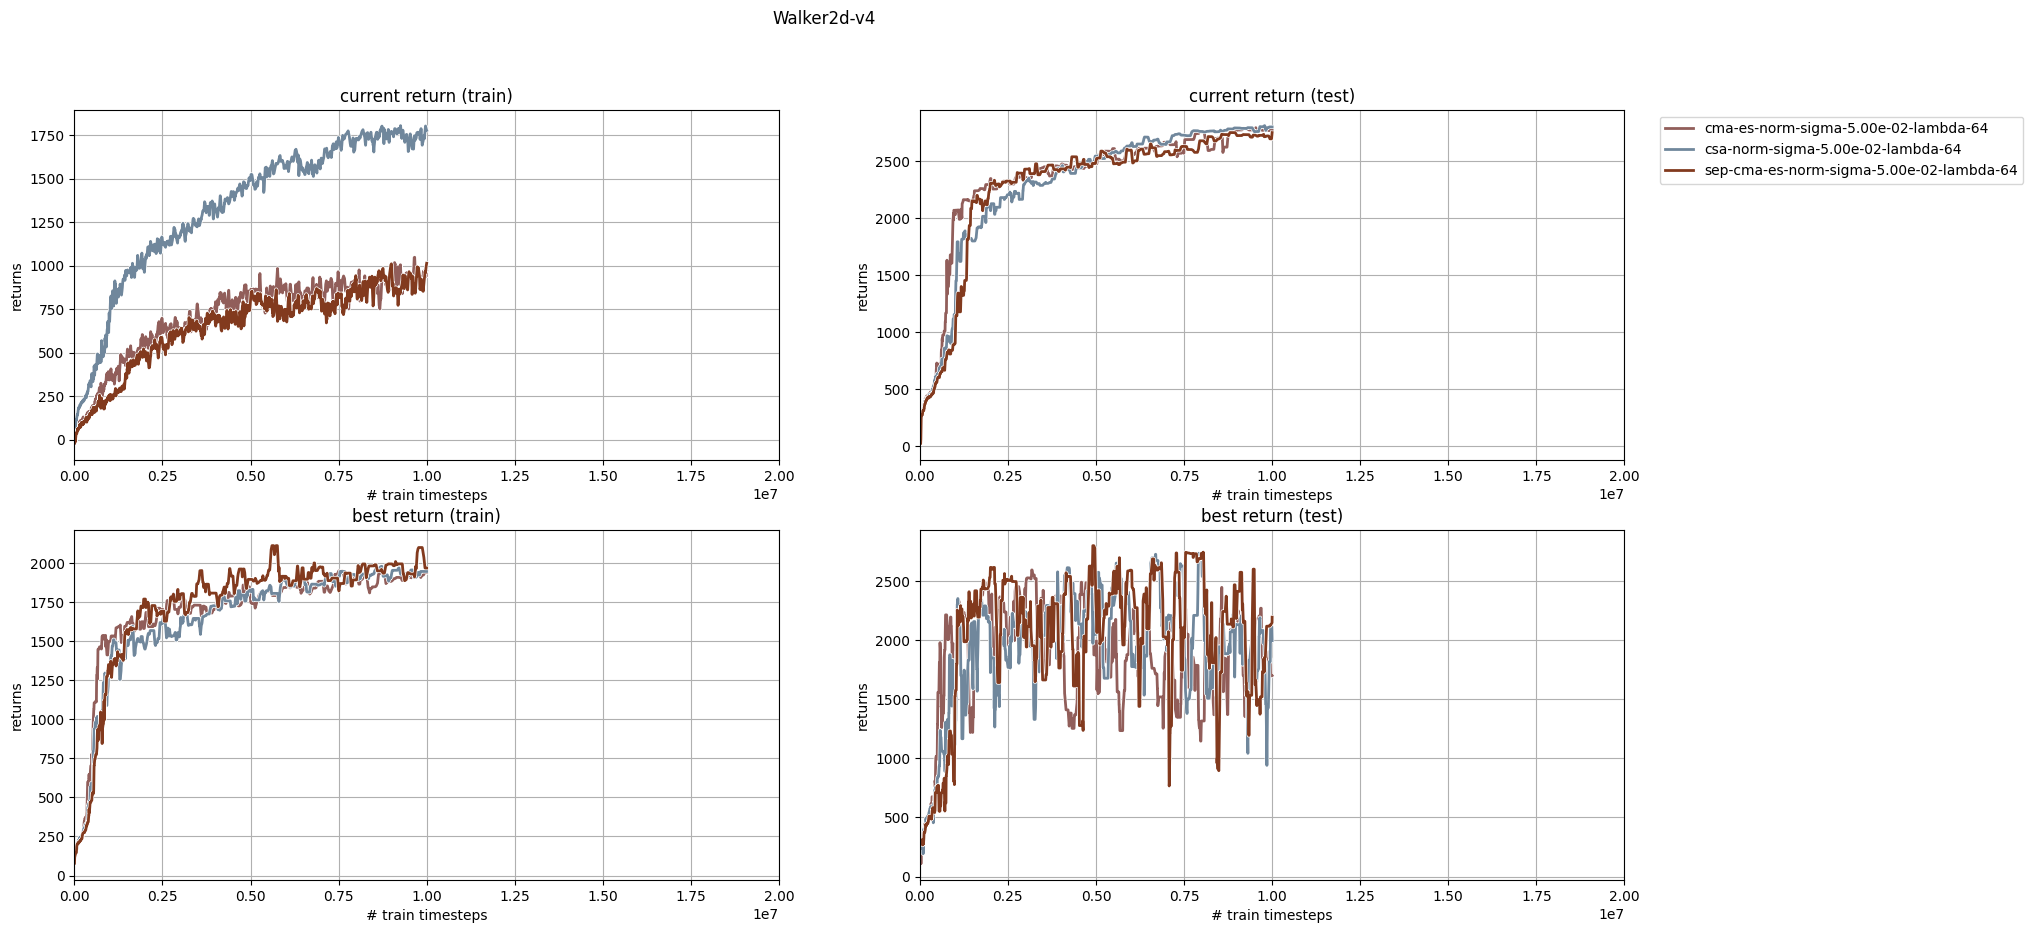

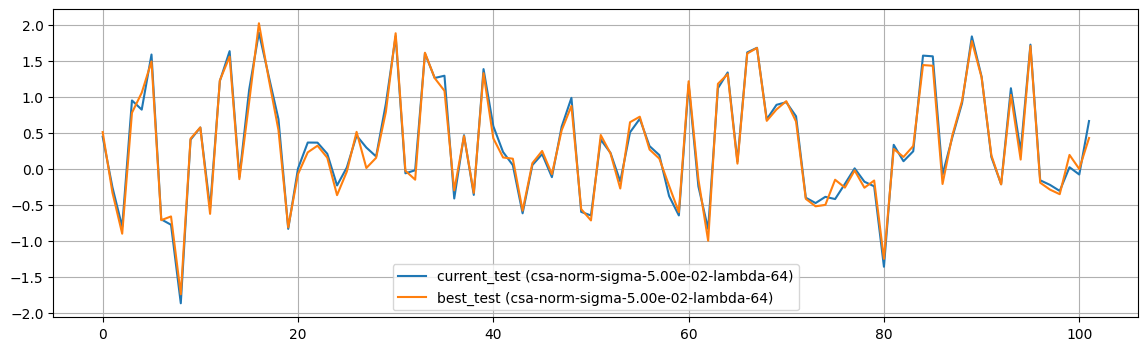

In [4]:
show_summary("data/Walker2d-v4-test", xlim=2e7);